### Produce Maps

In [1]:
import numpy as np
import os  # For Saving to Folder
import pandas as pd
import matplotlib.pyplot as plt

import socket
import os as os
import sys as sys
import multiprocessing as mp
import matplotlib.cm as cm
import matplotlib.colors as cls
import matplotlib.colorbar as clb
from matplotlib import gridspec

# For Arial Font
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'   # Set the defaul
# Make sure to have the font installed (it is on cluster for Harald)
rcParams['font.sans-serif'] = ['Arial']

socket_name = socket.gethostname()
print(socket_name)

if socket_name.startswith("compute-"):
    print("HSM Computational partition detected.")
    path = "/n/groups/reich/hringbauer/git/punic_aDNA/"  # The Path on HMS Cluster
else:
    raise RuntimeWarning("Not compatible machine. Check!!")

os.chdir(path)  # Set the right Path (in line with Atom default)
# Show the current working directory. Should be HAPSBURG/Notebooks/ParallelRuns
print(os.getcwd())
print(f"CPU Count: {mp.cpu_count()}")
print(sys.version)

import mpl_toolkits
mpl_toolkits.__path__.append('/n/groups/reich/hringbauer/explore_ntbk/jptvenv37/lib/python3.7/site-packages/basemap-1.2.1-py3.7-linux-x86_64.egg/mpl_toolkits/')
from mpl_toolkits.basemap import Basemap

compute-e-16-231.o2.rc.hms.harvard.edu
HSM Computational partition detected.
/n/groups/reich/hringbauer/git/punic_aDNA
CPU Count: 28
3.7.4 (default, Sep 11 2019, 11:24:51) 
[GCC 6.2.0]


# Helper Function

In [4]:
def remove_individuals(df, remove_list=["_d"], iid_col="iid"):
    """Remove indivdiuals from PCA dataframe"""
    idx = df[iid_col].str.contains("|".join(remove_list))
    df = df[~idx].copy()
    print(f"Filtering to {len(df)}/{len(idx)}")
    return df

def get_sub_iid(df, pops=[""], iid_col="iid"):
    """Remove indivdiuals from PCA dataframe"""
    idx = df[iid_col].str.contains("|".join(pops))
    df = df[idx].copy()
    print(f"Found: {len(df)}/{len(idx)}")
    return df

def get_sub_pops(df, pop_list=[], pop_col="pop"):
    """Get Sub Populations"""
    idx = df[pop_col].str.contains("|".join(pop_list))
    df = df[idx].copy()
    print(f"Found: {len(df)}/{len(idx)}")
    return df

def get_sub_pops_exact(df, pop_list=[], pop_col="pop"):
    """Get Sub Populations"""
    idx = df[pop_col].isin(pop_list)
    df = df[idx].copy()
    print(f"Found: {len(df)}/{len(idx)}")
    return df

# Get the Data

In [28]:
min_snp = 30000
path_pca = "./output/pca/v44/20201116.punic1.v44_HO.construct_WE_NA_PCA.shrinkmode.evec.txt"

df = pd.read_csv(path_pca, 
                 sep=r"\s+", skiprows=1, header=None)
df.columns=["iid", "pc1", "pc2", "pc3", "pc4", "pop"]
df = remove_individuals(df, remove_list=["_d"])

df_meta = pd.read_csv("/n/groups/reich/hringbauer/Data/v44.0.anno.csv", sep=",")
df2 = df_meta[["iid", "Master ID", "loc", "n_cov_snp", "avg_cov_snp", "sex", "age"]]
df = pd.merge(df, df2, on="iid", how="left")
idx = (df["n_cov_snp"]<min_snp)
df = df[~idx]
df.loc[df["loc"].isnull(), "loc"]="not assigned"
print(f"Filtered to {len(df)} Individuals based on Min SNP: {min_snp}")

df = df.sort_values(by="n_cov_snp", ascending=False)
dup = (df["Master ID"].duplicated() & ~df["Master ID"].isnull())
df = df[~dup].copy().reset_index(drop=True)
print(f"Filtered to {len(df)} based on duplicates")

Filtering to 2020/2131
Filtered to 1967 Individuals based on Min SNP: 30000
Filtered to 1899 based on duplicates


In [30]:
df_sard = get_sub_pops(df, pop_list=["Italy_Sardinia_Punic"])

Found: 19/1899


# Do the Timeline Plot

In [62]:
def plot_timeline(df, fs = 10, c = "royalblue", xlim=[0,700], ylim=[1e-2, 1.25e1],
                  x_ticks = [0.1, 1,10], s=70, savepath=""):
    """Plot timeline of samples"""
    x, y = df["age"].values-1950, df["avg_cov_snp"].values.astype("float")
    txts = df["iid"].values

    plt.figure(figsize=(8,3))
    ax = plt.gca()
    ax.scatter(x, y, edgecolors="k", c=c, s=s)

    ax.invert_xaxis()
    ax.set_ylim(ylim)
    ax.set_xlim(xlim)
    ax.set_ylabel("Mean Coverage on 1240K SNPs", fontsize=fs)
    ax.set_xlabel("Age [years BCE]", fontsize=fs)
    ax.set_yscale("log")

    for i, txt in enumerate(txts):
        plt.text(x[i], y[i]*1.25, txt, fontsize=9)

    # Horizontal Lines:

    for x in x_ticks:
        ax.axhline(x, color="gray", linestyle="dashed", linewidth=0.5, zorder=0)

    ax.axhline(0.024, color="red", linestyle="-", linewidth=0.5, zorder=0)
    if len(savepath)>0:
        plt.savefig(savepath, bbox_inches = 'tight', pad_inches = 0)
        print(f"Saved to {savepath}")  
    plt.show()

In [64]:
len(df_sard)

19

Saved to ./figures/timeline/timeline.pdf


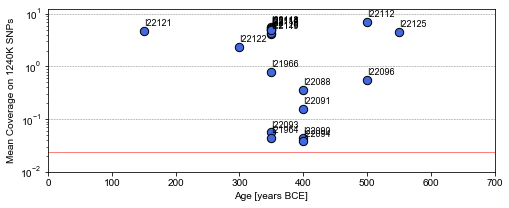

In [63]:
plot_timeline(df_sard, savepath="./figures/timeline/timeline.pdf")

In [32]:
 df_sard["avg_cov_snp"]

112    5.509
123    5.296
143    4.219
145    7.051
155    4.584
156    4.827
167    4.794
168     5.12
176    4.377
188    4.958
198    2.335
296    0.778
318    0.552
380    0.361
435    0.155
530    0.056
551    0.044
554    0.043
558    0.038
Name: avg_cov_snp, dtype: object